# LightGBM DGA binary model

## Columns to be removed from training/validation

In [8]:
#disqualified_columns = ["tls_joint_isoitu_policy_crt_count", "rdap_time_from_last_change"]
disqualified_columns = ["tls_joint_isoitu_policy_crt_count", "rdap_time_from_last_change", "lex_www_flag"]


## Prefix of preserved features

In [9]:
prefix = "lex_"

# Dataset preparation

In [10]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

from pyarrow import Table
from pandas import DataFrame, api, Int64Dtype
from pandas.core.dtypes import common as com
import sys
sys.path.append('..')
from utils.preprocess import NDF

def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

##################################
# EDIT to specify the model name #
##################################
model_name = "dga_lgbm_binary_model"     
##################################

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/lex-benign_2312_anonymized.parquet',
    '../feature-extraction/floor/lex-umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

# Unify malicious datasets and benign datasets
malicious_schema = pq.read_table(malicious_dataset_filenames[0]).schema  # Use the schema from the first malicious filename
malicious_columns = set(malicious_schema.names)  # Get the columns in the malicious schema

# Process benign tables to ensure only columns in the malicious schema are preserved
benign_tables = []
for filename in benign_dataset_filenames:
    table = pq.read_table(filename)
    table = table.select([col for col in table.column_names if col in malicious_columns])
    table = table.cast(malicious_schema)
    benign_tables.append(table)

# Process malicious tables
malicious_tables = [pq.read_table(filename).cast(malicious_schema) for filename in malicious_dataset_filenames]

# Union the tables
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)
# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label

# Merge the dataframes together
df = merged_df = pd.concat([df_benign, df_malicious], ignore_index=True)
class_map = {benign_label: 0, malicious_label: 1}

# Drop the domain name column
df.drop('domain_name', axis=1, inplace=True)

# Cast timestamps
df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df.columns:
        df.drop(column, axis=1, inplace=True)

df

,label,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_benign_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_tld_hash,lex_sld_len,...,lex_long_part_count,lex_superlong_part_count,lex_shortest_sub_len,lex_ipv4_in_domain,lex_has_trusted_suffix,lex_has_wellknown_suffix,lex_has_cdn_suffix,lex_has_vps_suffix,lex_has_img_suffix,lex_suffix_score
0,benign,23,1,0,1,6,2,0.0000,1802987263,8,...,0,0,18,0,0,0,0,0,0,0
1,benign,24,1,0,1,6,2,0.0000,1802987263,8,...,0,0,19,0,0,0,0,0,0,0
2,benign,8,1,0,0,5,2,0.0000,1221550071,5,...,0,0,5,0,0,0,0,0,0,0
3,benign,26,1,0,0,5,2,0.0000,3967155703,5,...,1,0,21,0,0,0,0,0,0,0
4,benign,26,1,0,0,4,2,0.0000,3967155703,5,...,1,0,21,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645870,dga,14,0,0,0,2,3,0.6554,3649657627,10,...,0,0,10,0,0,0,0,0,0,0
1645871,dga,19,0,0,0,1,3,0.1040,3946931378,15,...,1,0,15,0,0,0,0,0,0,0
1645872,dga,15,0,1,0,1,4,0.0043,3105607653,10,...,0,0,10,0,0,0,0,0,0,0
1645873,dga,32,1,0,0,1,3,0.1040,3946931378,28,...,1,0,28,0,0,0,0,0,0,0


In [11]:
# Convert the unique feature names to a list
#feature_names_list = ndf_dataset['feature_names'].unique().tolist()

# Print each feature name individually
#for feature in feature_names_list:
#    print(feature)


# Model validation function

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Helpers
from kneed import KneeLocator

def plot_metric(metric):
    plt.rcParams["figure.dpi"] = 300
    
    # Plot metric curves
    plt.plot(x_axis, results['training'][metric], label='Training set')
    plt.plot(x_axis, results['valid_1'][metric], label='Testing set')
    
    # Detect elbow using Kneedle algorithm
    kn = KneeLocator(x_axis, results['valid_1'][metric], curve='convex', direction='decreasing')
    if kn.knee:
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))
    
    plt.legend()
    mnames = {'error': 'Classification Error', 'binary_logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames.get(metric, metric)  # Return the metric itself if it's not in the dictionary
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('LightGBM ' + mname)
    plt.show()

    
# Tuning - graphs
def DisplayTuningGraph(scores):
    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
    print(scores)

def ValidateModel_advanced(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

    # Plotting ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Model-specific evaluations
    if isinstance(model, (XGBClassifier, LGBMClassifier)):
        
        if isinstance(model, (XGBClassifier)):
            results = model.evals_result()
        elif isinstance(model, (LGBMClassifier)):
            results = model.evals_result_

        training_key = 'training' if isinstance(model, LGBMClassifier) else 'validation_0'
        validation_key = 'valid_1' if isinstance(model, LGBMClassifier) else 'validation_1'
        
        print("Training metrics:", results[training_key].keys())
        print("Validation metrics:", results[validation_key].keys())

        trees = len(results[validation_key]['binary_logloss']) if isinstance(model, LGBMClassifier) else len(results[validation_key]['logloss'])
        x_axis = range(0, trees)

        def plot_metric(metric):
            plt.rcParams["figure.dpi"] = 300

            # Plot metric curves
            plt.plot(x_axis, results[training_key][metric], label='Training set')
            plt.plot(x_axis, results[validation_key][metric], label='Validation set')

            # Detect elbow using Kneedle algorithm
            kn = KneeLocator(x_axis, results[validation_key][metric], curve='convex', direction='decreasing')
            if kn.knee:
                plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))

            plt.legend()
            mnames = {'binary_logloss': 'Log Loss', 'auc': 'AUC'}
            mname = mnames.get(metric, metric)
            plt.ylabel(mname)
            plt.xlabel('Number of trees')
            plt.title(f'{type(model).__name__} {mname}')
            plt.show()

        if isinstance(model, LGBMClassifier):
            plot_metric('binary_logloss')
        elif isinstance(model, XGBClassifier):
            plot_metric('logloss')
            
        plot_metric('auc')
        
    elif isinstance(model, (RandomForestClassifier, AdaBoostClassifier)):
        # For RandomForest and AdaBoost, additional model-specific evaluations can be added here
        pass
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot

# LightGBM

In [13]:
from sklearn.model_selection import train_test_split

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

## LightGBM model Training

In [16]:
import joblib
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    "objective": "binary",  # binary classification
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "n_estimators": 230, # Number of boosted trees to fit, equivalent to number of boosting iterations
    "num_leaves": 8,
    "max_depth": 10,
    "learning_rate": 0.04,
    "objective": "binary",
    "min_child_samples": 10,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.15,
    "reg_lambda": 0.2,
    "scale_pos_weight": 0.01, # Positive class weight
    "subsample_for_bin": 240000,
    "random_state": 7,
}


model = lgb.LGBMClassifier(**params, metric=['error', 'binary_logloss', 'auc'])

# at last, train the model
eval_set = [(X_train, Y_train), (X_test, Y_test)]
_ = model.fit(X_train, Y_train, eval_set=eval_set)

# Save the model to a file
joblib.dump(model, 'models/' + model_name + '.joblib')

[LightGBM] [Info] Number of positive: 664315, number of negative: 652385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3857
[LightGBM] [Info] Number of data points in the train set: 1316700, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504530 -> initscore=0.018122
[LightGBM] [Info] Start training from score 0.018122


['models/dga_lgbm_binary_model.joblib']

## LightGBM model Validation

              precision    recall  f1-score   support

           0     0.8196    0.9992    0.9005    163096
           1     0.9991    0.7840    0.8785    166079

    accuracy                         0.8906    329175
   macro avg     0.9093    0.8916    0.8895    329175
weighted avg     0.9101    0.8906    0.8894    329175

Confusion Matrix:
TN: 162973 FP: 123 FN: 35879 TP: 130200


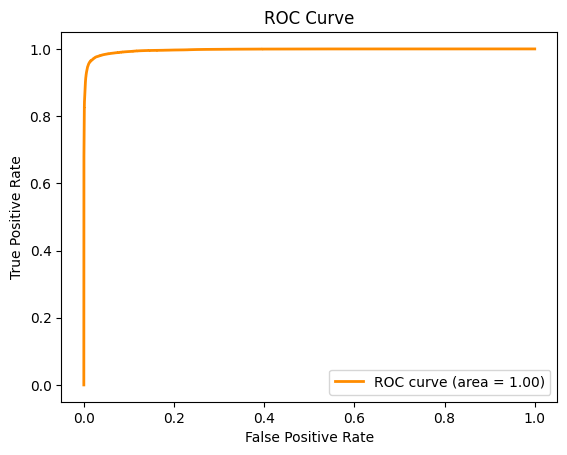

Training metrics: odict_keys(['binary_logloss', 'auc'])
Validation metrics: odict_keys(['binary_logloss', 'auc'])


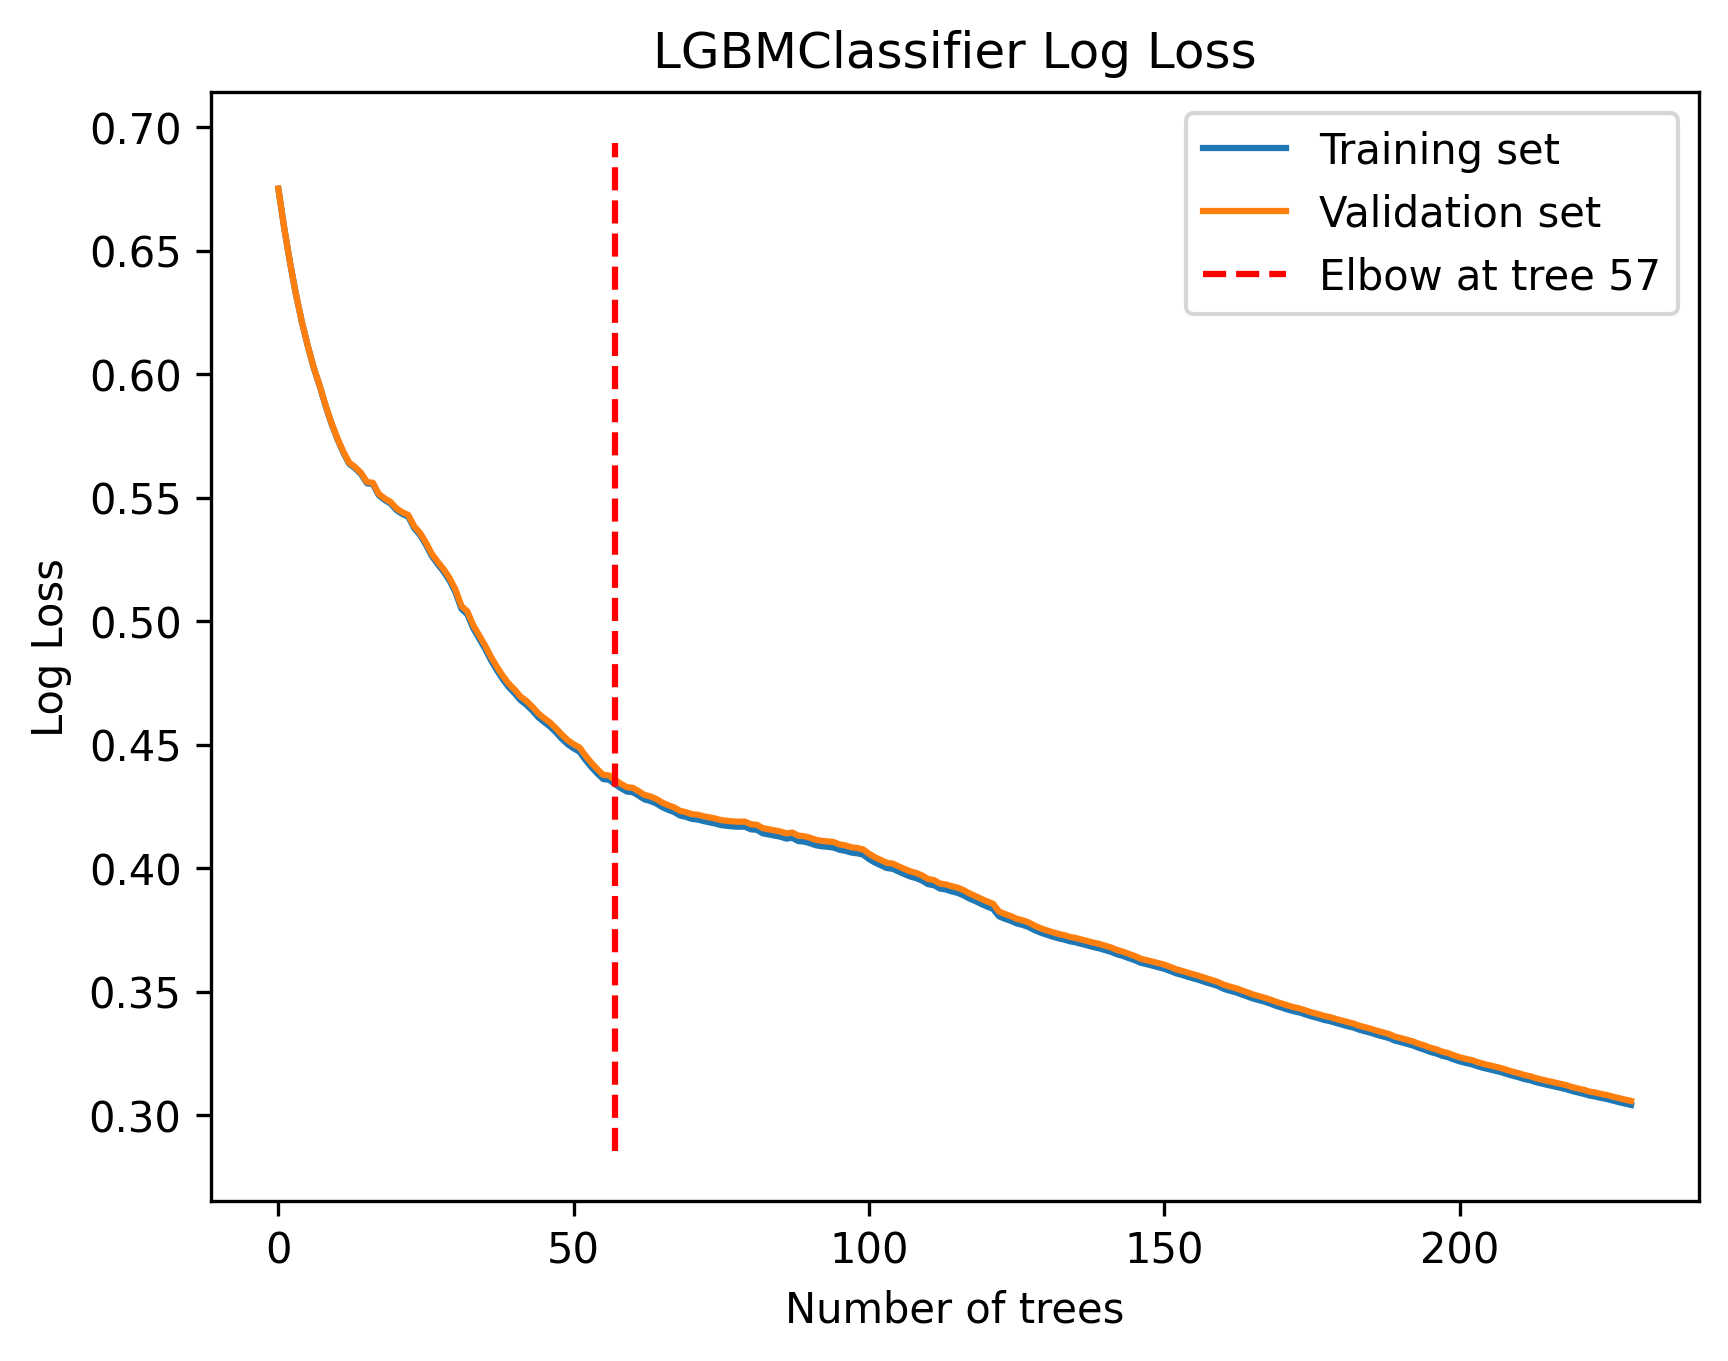

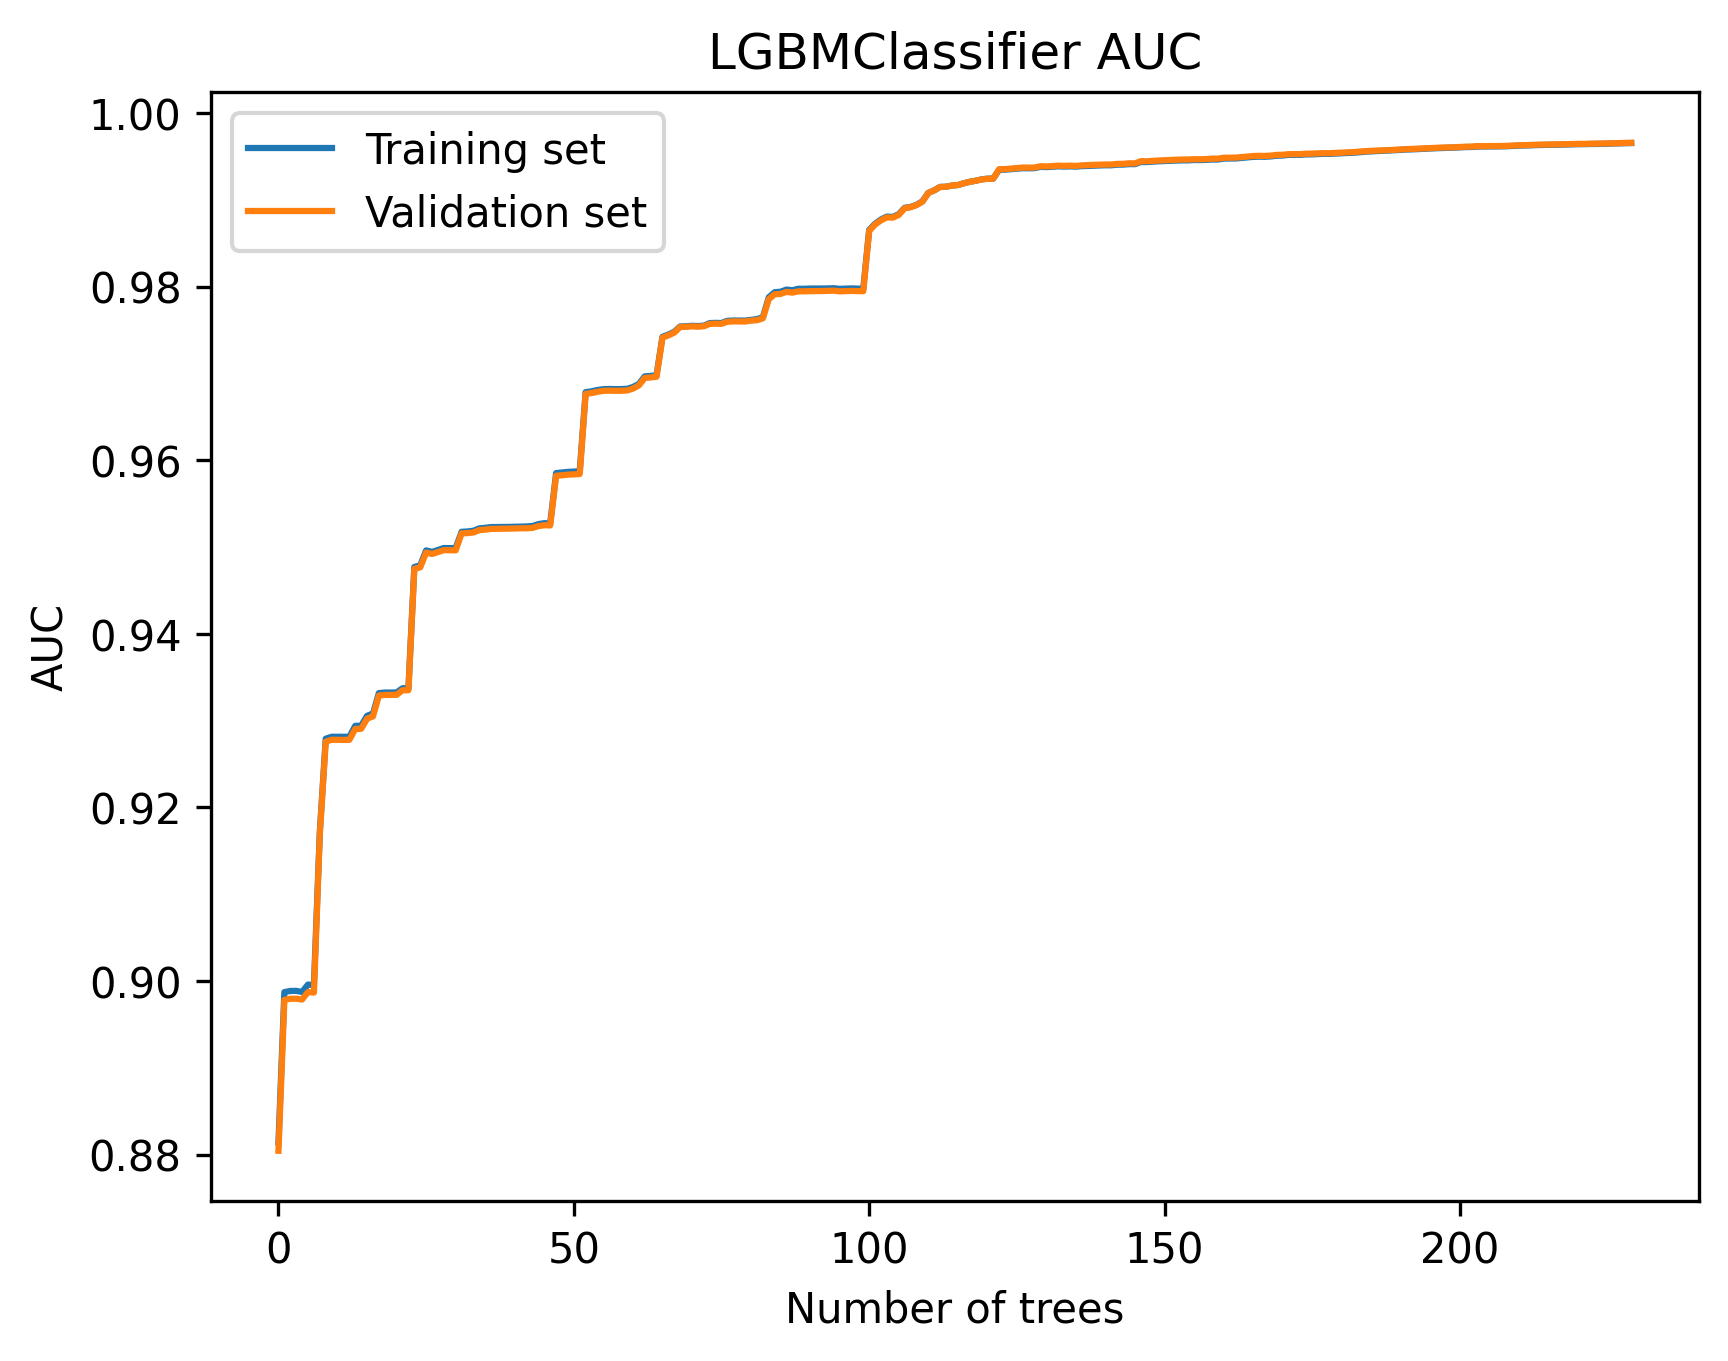

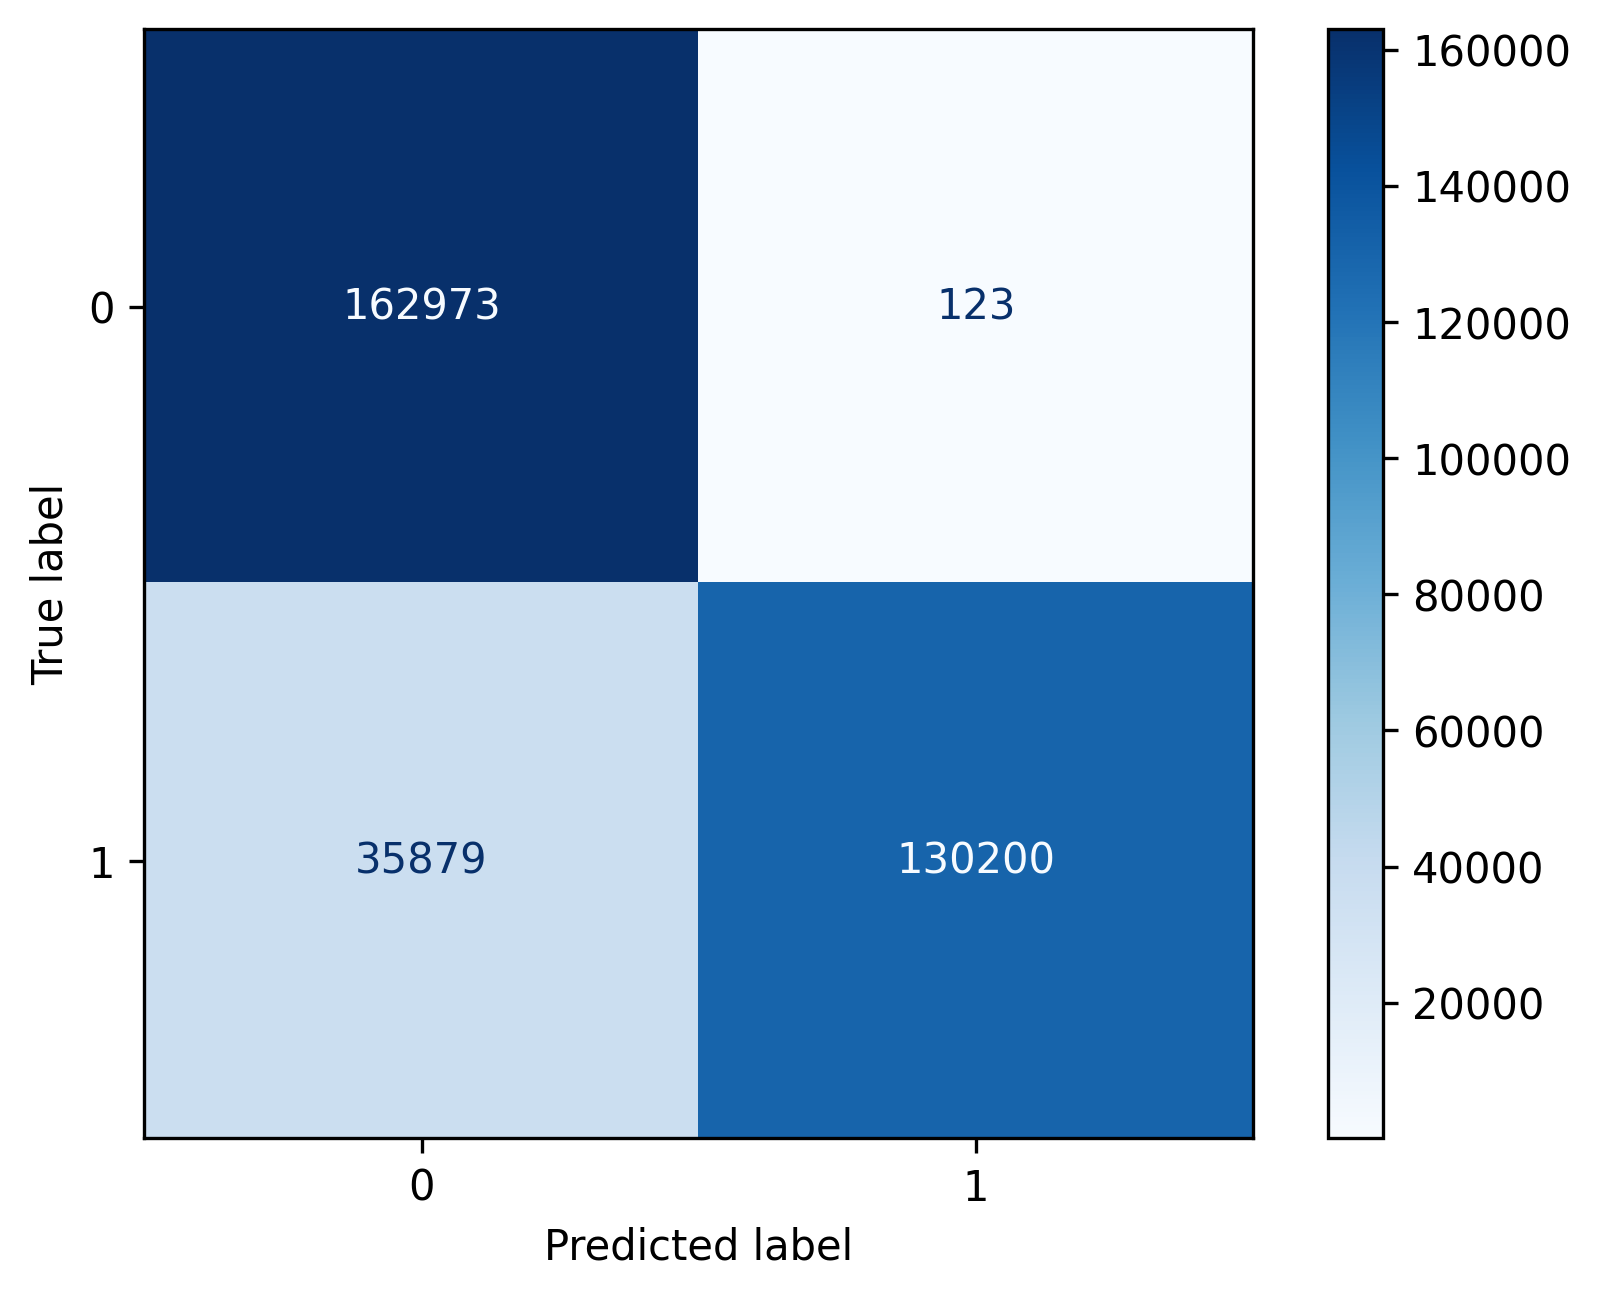

In [17]:
ValidateModel_advanced(X_test, Y_test, model)

## LightGBM model Tuning

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, log_loss

def FETA_Score(estimator, X, y):
    # Getting predictions
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    
    # Calculating precision
    precision = precision_score(y, y_pred)
    
    # Calculating recall
    recall = recall_score(y, y_pred)
    
    # Calculating F1-score
    f1 = f1_score(y, y_pred)
    
    # Calculating FPR
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculating Log Loss
    logloss = log_loss(y, y_pred_proba)
    
    # Estimating overfitting
    train_score = estimator.score(X_train, y_train) 
    validation_score = estimator.score(X, y) 
    overfitting = train_score - validation_score
    
    # Assigning weights
    w_precision = 0.1     # Precision
    w_recall = 0.1        # Recall
    w_f1 = 0.6            # F1
    w_fpr = -0.0          # Negative because lower FPR is better
    w_logloss = -0.0      # Negative because lower log loss is better
    w_overfitting = -0.2  # Negative because lower overfitting is better
    
    #w_precision = 0.0     # Precision
    #w_recall = 0.5        # Recall
    #w_f1 = 0.5            # F1
    #w_fpr = -0.0          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.0  # Negative because lower overfitting is better
    
    # Assigning weights
    #w_precision = 0.1     # Precision
    #w_recall = 0.1        # Recall
    #w_f1 = 0.4            # F1
    #w_fpr = -0.1          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.5  # Negative because lower overfitting is better
    
    # Combining metrics with weights
    combined_score = (w_precision * precision + w_recall * recall + w_f1 * f1 + w_fpr * fpr + w_overfitting * overfitting)
    
    return combined_score


In [19]:
lgbm_tuning = False

if lgbm_tuning:
    import pandas as pd
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from lightgbm import LGBMClassifier  # Updated import

    params = {
        "objective": "binary",  # binary classification
        "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
        "n_estimators": 230, # Number of boosted trees to fit, equivalent to number of boosting iterations
        "num_leaves": 8,
        "max_depth": 10,
        "learning_rate": 0.04,
        "objective": "binary",
        "min_child_samples": 10,
        "colsample_bytree": 0.9,
        "reg_alpha": 0.15,
        "reg_lambda": 0.2,
        "scale_pos_weight": 0.01, # Positive class weight
        "subsample_for_bin": 240000,
        "random_state": 7,
    }


    clf = LGBMClassifier(**params)  # Updated classifier instantiation

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "n_estimators": [600, 700, 800],
        "max_depth": [10, 12, 14, 16, 18],
        #"n_estimators": [897],
        #"num_leaves": [59],
        #"max_depth": [20],
        #"learning_rate": [0.11, 0.12, 0.13, 0.2],
        #'scale_pos_weight': [1.7, 1.8, 1.9],
        #"subsample": [0.1],
        #reg_lambda": [0.1],
        #'min_split_gain' : [0.0, 0.1, 0.2]
        #'subsample_for_bin': [215000, 220000, 230000, 240000],
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        #scoring='neg_log_loss',
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, Y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)



In [20]:
a = ""
if lgbm_tuning:
    DisplayTuningGraph(scores)
    a = scores

a

''

# Test on another Validation dataset

In [23]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import shap
from pandas.core.dtypes import common as com
import numpy as np

def cast_timestamp(df: pd.DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)
    return df

# Load the validation dataset
validation_dataset_filename = '../testdata/validation_dga.parquet'
df_validation = pq.read_table(validation_dataset_filename).to_pandas()

# Cast timestamps and handle NaNs
df_validation = cast_timestamp(df_validation)
df_validation.fillna(-1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df_validation.columns:
        df_validation.drop(column, axis=1, inplace=True)

columns_to_keep = [col for col in df_validation.columns if col.startswith(prefix)] + ['label', 'domain_name']
df_validation = df_validation[columns_to_keep]

# Map the labels
df_validation['label'] = df_validation['label'].map({'benign': 0, 'phishing': 1})

# Extract features and labels
X_val = df_validation.drop(['label', 'domain_name'], axis=1)
y_val = df_validation['label']

# Load the trained model
model = joblib.load('models/' + model_name + '.joblib')

# Make predictions
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
weighted_accuracy = (accuracy_score(y_val[y_val == 0], y_pred[y_val == 0]) + accuracy_score(y_val[y_val == 1], y_pred[y_val == 1])) / 2
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
false_positive_rate = fp / (fp + tn)

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Weighted Accuracy: {weighted_accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'False Positive Rate: {false_positive_rate}')

# Display confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'phishing'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Identify misclassified domain names
misclassified = df_validation[y_val != y_pred]
misclassified_domains = misclassified['domain_name'].tolist()
print(f'Misclassified domains: {misclassified_domains}')

invalid value encountered in cast


ValueError: Input y_true contains NaN.

In [ ]:
import shap

def display_shap_for_misclassified(model, misclassified, top_n=30):
    # Select the first N misclassified domains
    misclassified_subset = misclassified.head(top_n)

    # Extract features for the misclassified subset
    X_misclassified = misclassified_subset.drop(['label', 'domain_name'], axis=1)

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_misclassified)

    # Plot SHAP values for the misclassified domains
    for i in range(len(misclassified_subset)):
        domain_name = misclassified_subset.iloc[i]['domain_name']
        print(f'Domain: {domain_name}')
        shap.initjs()
        shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_misclassified.iloc[i], matplotlib=True)

# Display SHAP values for the first N misclassified domains
display_shap_for_misclassified(model, misclassified, top_n=30)


# Advanced tuning - Training on Training portion, Validation on Validation

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 148092, number of negative: 653059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16329
[LightGBM] [Info] Number of data points in the train set: 801151, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184849 -> initscore=-1.483834
[LightGBM] [Info] Start training from score -1.483834
[CV 1/1] END reg_lambda=0.18;, score=(train=0.684, test=0.704) total time=  10.3s
[LightGBM] [Info] Number of positive: 148092, number of negative: 653059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.394363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16329
[LightGBM] [Info] Number o

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      10.339023           0.0         0.007643             0.0   
1      12.132982           0.0         0.007689             0.0   
2       9.257500           0.0         0.007595             0.0   
3       9.804970           0.0         0.009653             0.0   
4       9.155455           0.0         0.007606             0.0   

   param_reg_lambda                params  split0_test_score  mean_test_score  \
0              0.18  {'reg_lambda': 0.18}           0.703704         0.703704   
1              0.20   {'reg_lambda': 0.2}           0.714286         0.714286   
2              0.25  {'reg_lambda': 0.25}           0.690037         0.690037   
3              0.30   {'reg_lambda': 0.3}           0.701887         0.701887   
4              0.40   {'reg_lambda': 0.4}           0.697761         0.697761   

   std_test_score  rank_test_score  split0_train_score  mean_train_score  \
0             0.0                2

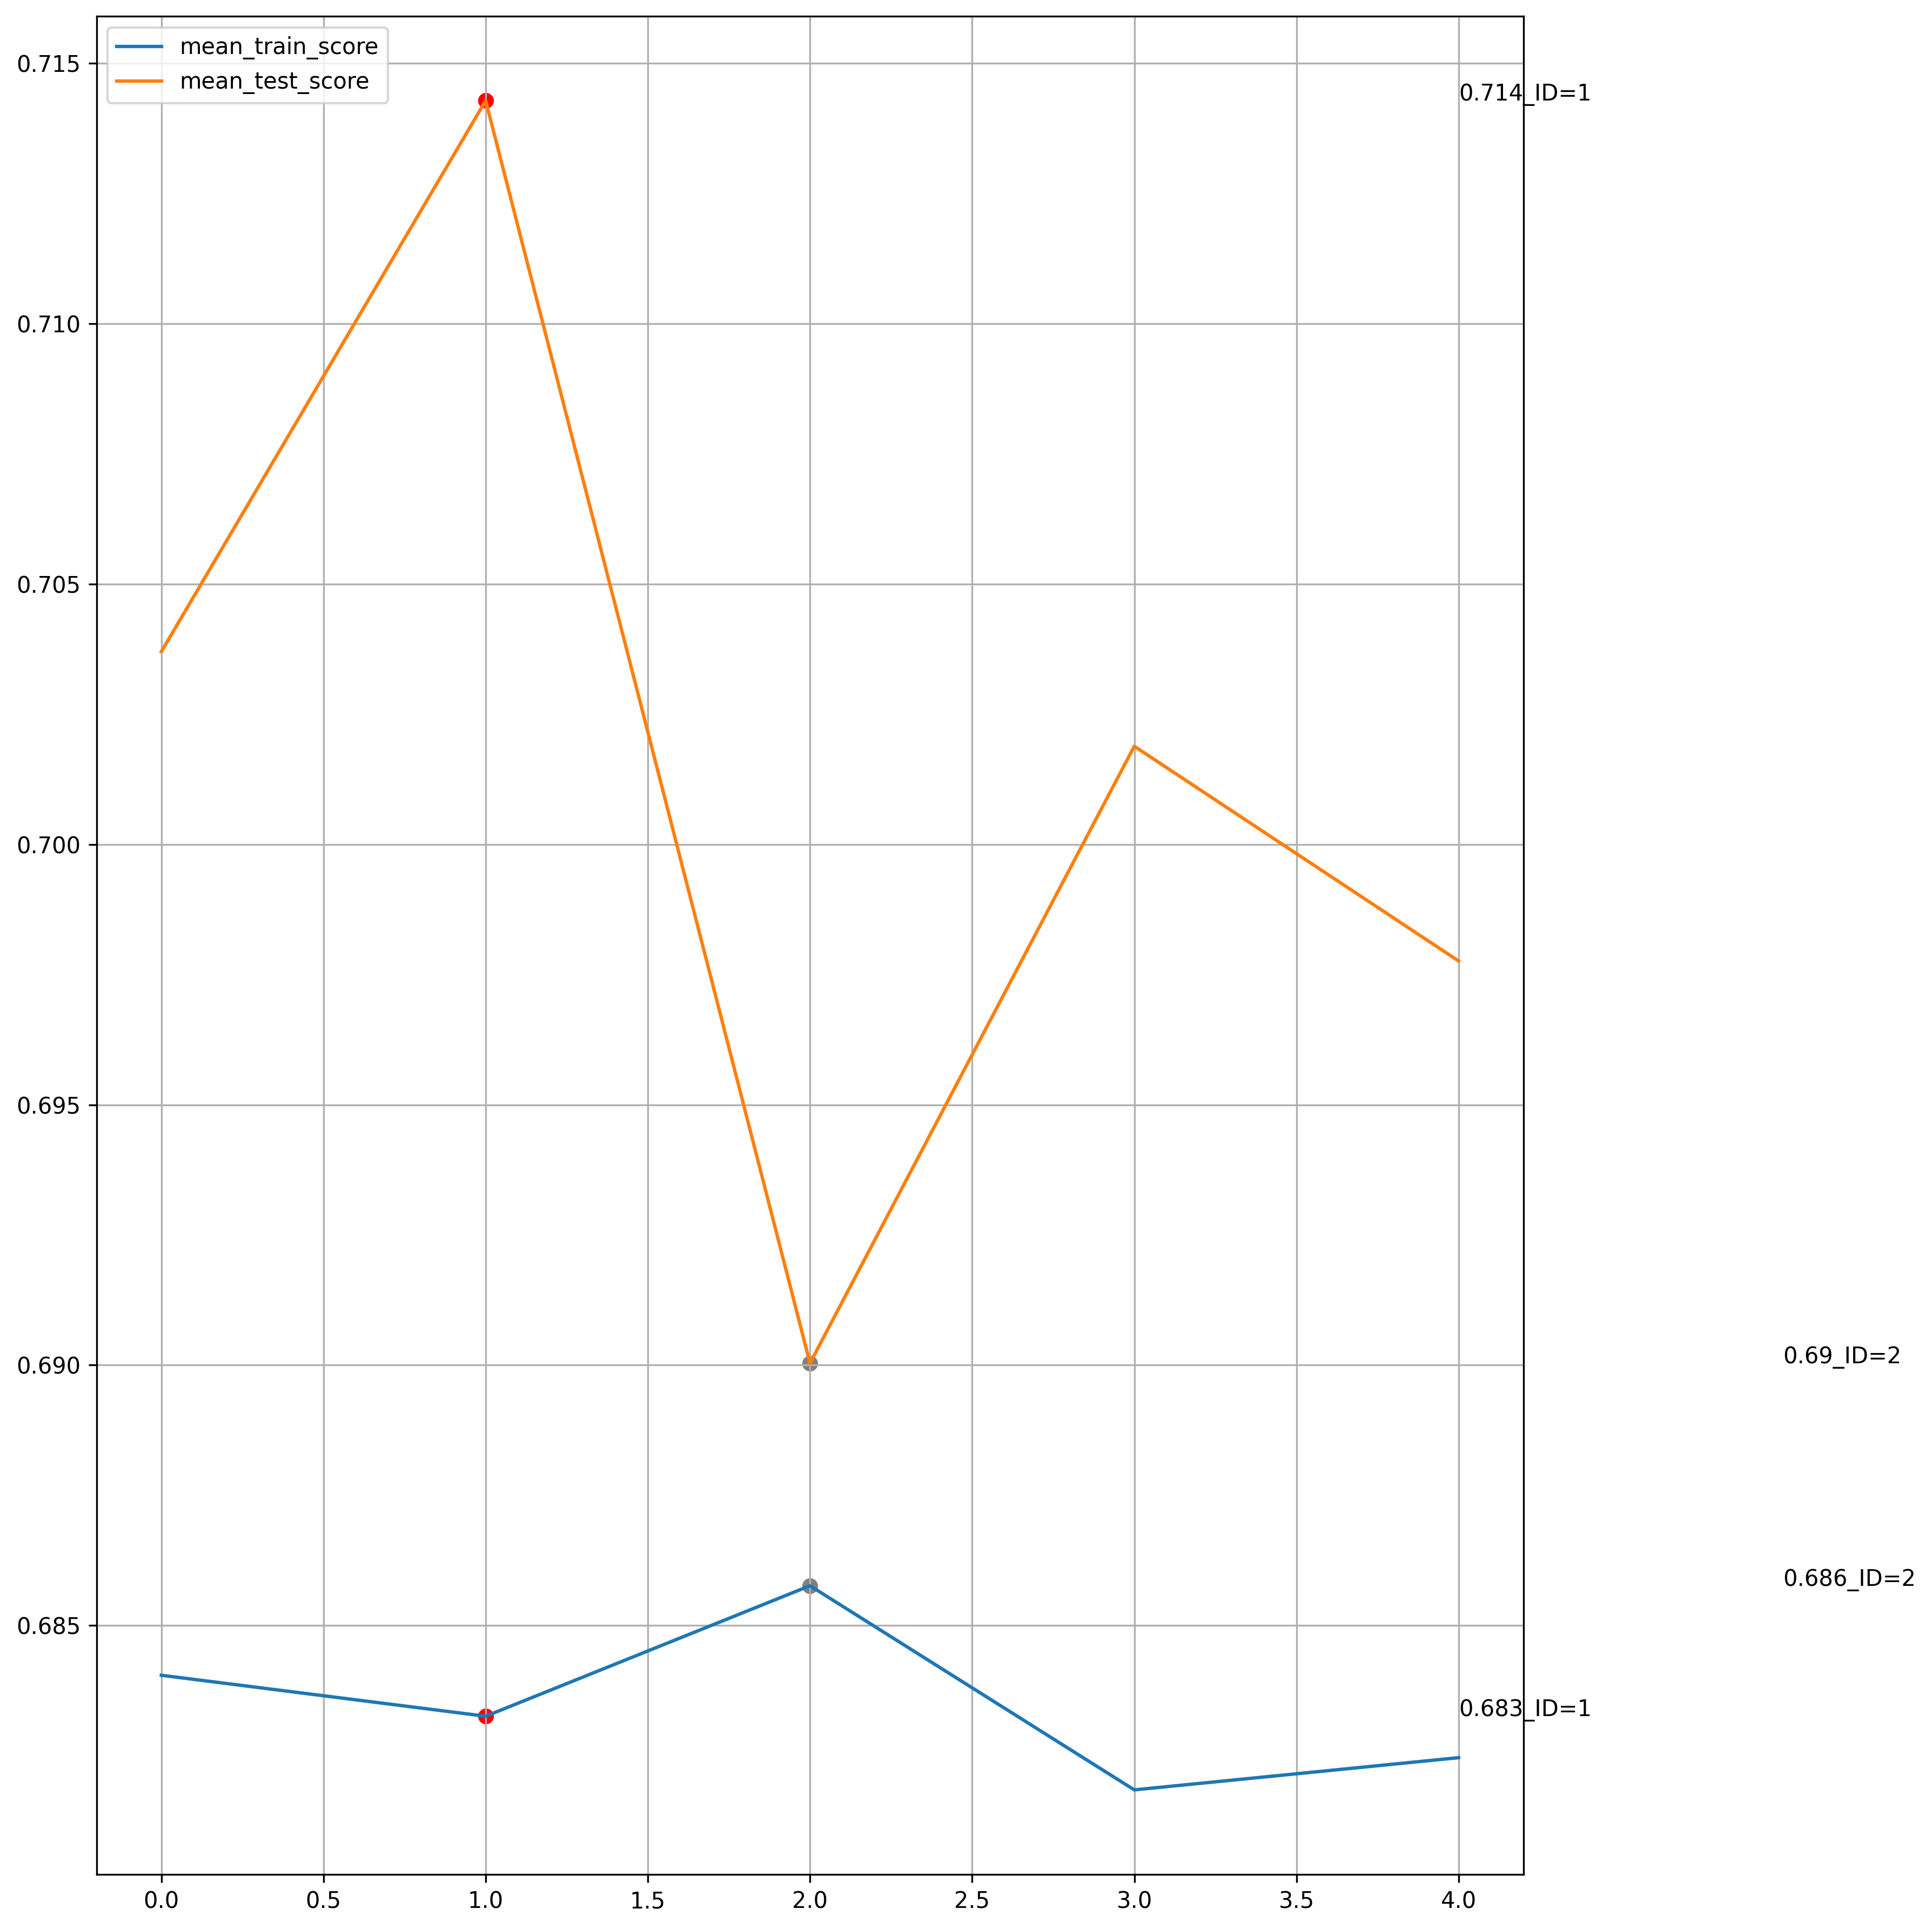

In [83]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from lightgbm import LGBMClassifier
import joblib

# Load the validation dataset
validation_dataset_filename = '../testdata/validation_dga.parquet'
df_validation = pq.read_table(validation_dataset_filename).to_pandas()

# Drop disqualified columns if they exist
for column in disqualified_columns:
    if column in df_validation.columns:
        df_validation.drop(column, axis=1, inplace=True)

# Cast timestamps and handle NaNs
df_validation = cast_timestamp(df_validation)
df_validation.fillna(-1, inplace=True)

# Map the labels
df_validation['label'] = df_validation['label'].map({'benign': 0, 'dga': 1})

# Extract features and labels from validation dataset
X_val = df_validation.drop(['label', 'domain_name'], axis=1)
y_val = df_validation['label']

# Combine the training and validation datasets
X_combined = pd.concat([X_train, X_val], ignore_index=True)
y_combined = pd.concat([Y_train, y_val], ignore_index=True)

# Create the test_fold array for PredefinedSplit
train_size = len(X_train)
test_size = len(X_val)
test_fold = [-1] * train_size + [0] * test_size  # -1 for training, 0 for validation

ps = PredefinedSplit(test_fold=test_fold)

lgbm_tuning = True  # Set to True to enable tuning

if lgbm_tuning:
    params = {
        "objective": "binary",  # binary classification
        "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
        #"n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
        "n_estimators": 230,
        "num_leaves": 8,
        #"max_depth": 17,
        "max_depth": 8,
        "learning_rate": 0.04,
        "objective": "binary",
        "min_child_samples": 10,
        "colsample_bytree": 0.9,
        "reg_alpha": 0.15,
        "reg_lambda": 0.2,
        "scale_pos_weight": 0.01,
        "subsample_for_bin": 240000,
        "random_state": 7,
    }


    clf = LGBMClassifier(**params)

    # Grid of parameters to search through
    grid = {
        #"num_leaves": [6,7,8,9],
        #"n_estimators": [200, 210, 220, 230],
        #"colsample_bytree": [0.9,1.0],
        "reg_lambda": [0.18, 0.2, 0.25, 0.3, 0.4],
        #"max_depth": [8, 9, 10],
        #"scale_pos_weight": [0.01, 0.05, 0.1, 0.2, 0.3],
        #"learning_rate": [0.03, 0.04, 0.05, 0.06],
        #"subsample_for_bin": [120000, 150000, 240000],
        #"learning_rate": [0.1, 0.2],
    }

    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        cv=ps,
        scoring='f1',  # You can change this to another scoring method if needed
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_combined, y_combined)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    # Save the best estimator
    joblib.dump(clf, 'models/' + model_name + '_best.joblib')

    # Display the best parameters
    print("Best parameters found: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Plot the tuning results
    def DisplayTuningGraph(scores):
        means_df = scores[col_names]
        ax = means_df.plot(kind='line', grid=True)

        plt.rcParams["figure.figsize"] = [12, 12]
        plt.rcParams["figure.autolayout"] = True
        plt.rcParams["figure.dpi"] = 300

        max_ids = means_df.idxmax(axis=0)

        for i in range(len(max_ids)):
            for col_name in col_names:
                value = means_df[col_name][max_ids[i]]
                id = max_ids[i]

                color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

                ax.scatter([id], [value],
                           marker='o',
                           color=color,
                           label='point',)

                ax.annotate(str(round(value, 3))+"_ID="+str(id),
                            (id, value),
                            xytext=(id+3, value))
        print(scores)

    DisplayTuningGraph(scores)


In [84]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,10.339023,0.0,0.007643,0.0,0.18,{'reg_lambda': 0.18},0.703704,0.703704,0.0,2,0.684043,0.684043,0.0
1,12.132982,0.0,0.007689,0.0,0.20,{'reg_lambda': 0.2},0.714286,0.714286,0.0,1,0.683257,0.683257,0.0
2,9.257500,0.0,0.007595,0.0,0.25,{'reg_lambda': 0.25},0.690037,0.690037,0.0,5,0.685762,0.685762,0.0
3,9.804970,0.0,0.009653,0.0,0.30,{'reg_lambda': 0.3},0.701887,0.701887,0.0,3,0.681842,0.681842,0.0
4,9.155455,0.0,0.007606,0.0,0.40,{'reg_lambda': 0.4},0.697761,0.697761,0.0,4,0.682460,0.682460,0.0


In [72]:

from skopt import BayesSearchCV

ModuleNotFoundError: No module named 'skopt'